In [1]:
import pandas as pd
import numpy as np
import json
import glob
import re
import nltk

from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
%matplotlib inline

import warnings 
warnings.filterwarnings("ignore")

import seaborn as sns

In [2]:
from collections import Counter, defaultdict

In [3]:
import spacy
nlp=spacy.load('en_core_web_sm')

Read json file containing business information

In [4]:
path = 'C:\\WM Project\\yelp_dataset\\'
df = pd.read_json(path +'yelp_academic_dataset_business.json', lines=True)

 Filter dataframe for 'Restaurant' category, 'MA' State, 'Indian' Cuisine, and Selected Cities. Also, filter restaurants that has more than 100 reviews

In [5]:
all_retras = df[df['categories'].str.contains('Rest.*')==True]
restra_MA = all_retras[all_retras.state=='MA']
restra_MA_indian = restra_MA[restra_MA.categories.str.contains('Indian')]
del df
my_restras = restra_MA_indian[restra_MA_indian.city.isin(['Somerville','Cambridge', 'Jamaica Plain',
'Boston', 'Brookline', 'Allston', 'Quincy'])]
my_restras = my_restras[my_restras.review_count>100]

Sorted restaurants giving importance to the number of stars and then the number of reviews. Graded restaurants as Top, Mediocre and Bottom with 10 restaurants for each grade. Combine all restaurants

In [6]:

my_restras_sorted = my_restras.sort_values(["stars", "review_count"], ascending = (False, False))
top_restras=my_restras_sorted.iloc[0:10]
top_restras['Grade'] = 'Top'
mid_restras=my_restras_sorted.iloc[26:36]
mid_restras['Grade'] = 'Mediocre'
bottom_restras=my_restras_sorted.iloc[-10:]
bottom_restras['Grade'] = 'Bottom' 
combined_restras = [top_restras, mid_restras, bottom_restras]
my_restras_selected = pd.concat(combined_restras)

In [7]:
my_restras_selected.shape

(30, 15)

selected list of 30 resturants

In [8]:
my_business_id = list(my_restras_selected.business_id.unique())

get reviews data for selected business ids from multiple json files (reviews dataset was splitted in multiple files due to heavy volume)

In [9]:
df_test = pd.read_json(path + 'xaa.json',lines=True)
my_df_test = df_test[df_test.business_id.isin(my_business_id)]

In [10]:
file_list = glob.glob(path + "xa*.json")

In [11]:
main_dataframe = pd.DataFrame(pd.read_json(file_list[0],lines=True))
my_dataframe = main_dataframe[main_dataframe.business_id.isin(my_business_id)]

In [12]:
for i in range(1,len(file_list)):
    data = pd.read_json(file_list[i], lines=True)
    df = pd.DataFrame(data)
    my_dataframe_test = df[df.business_id.isin(my_business_id)]
    my_dataframe = pd.concat([my_dataframe,my_dataframe_test],axis=0, ignore_index=True)

In [13]:
my_dataframe.shape

(10350, 9)

In [14]:
my_restras_selected.to_csv('Selected_Restaurants_Info.csv')

In [15]:
my_dataframe.to_csv('Selected_Restaurants_Reviews.csv')

In [16]:
review_data = pd.read_csv('Selected_Restaurants_Reviews.csv')
business_data = pd.read_csv('Selected_Restaurants_Info.csv')

In [17]:
review_data

,Unnamed: 0,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,0,Do3JEdVlqxiSoV_q0i0GHA,HpHkpOyCX0gcFuvbKYHpCg,C--wIpxJ4j1y01G_raHdbA,5,1,0,1,"Wow. Thank you, Yelp.\nI am SO glad I found th...",2007-12-08 03:53:22
1,1,SjyigQPHeo5DEMt3Y0xXyQ,p8yQsVA51dzkc9cecDpvrw,HxegWRjhi7m73mXRI8qQIg,4,3,0,2,"I mostly eat here at lunch, for the tremendous...",2007-05-17 13:48:57
2,2,ckqQkgN_6E99JyrrpgCHlg,k1Qwwh_WqTbGby6rZNdg9Q,HxegWRjhi7m73mXRI8qQIg,5,5,1,2,"As a Nepali person, I get asked the difference...",2016-03-17 14:21:35
3,3,P5zpEmzurVIsQ394CsN5RQ,_97mTpkKuLB5x0UMledd7A,4UjU7F_EX3lgUtkzN8Bbrw,5,1,0,0,Ordered from here yesterday and loved their ch...,2016-02-11 23:36:46
4,4,u1E-LQaRBcdhcjHGT7kkjw,S3nCmgSpJmsThVwAcf9Opw,4UjU7F_EX3lgUtkzN8Bbrw,4,1,0,1,I ordered a large order from here via foodler ...,2017-04-19 17:13:44
...,...,...,...,...,...,...,...,...,...,...
10345,10345,QzVsrWUiLS_sX6QnKzHZgg,BovkrYDODcINKe71da2qvw,tQbYsSvTAIV6uzZfMvdI2A,1,1,0,0,"I'm sorry, They were nice enough but the food ...",2017-12-12 17:54:30
10346,10346,2cPQnI9h6fzQCgLAttg18A,0gCtnERzLtxa-0QRxXgPeg,L9S4WSPE3r1Bg9KgIlTqpA,3,2,0,0,We stopped here during our road trip last week...,2020-10-20 15:32:48
10347,10347,PZE_8FRUDiiiDkcI4eQIWQ,b82t-3QGw2t3XQeU4Ckwcw,L9S4WSPE3r1Bg9KgIlTqpA,4,1,0,2,Tasty Indian restaurant with a lively view of ...,2019-01-29 01:28:20
10348,10348,H-5sZC1EK9MrBzfgWHSY3g,uu6kRHJCbv1MEN9QLiIlwA,L9S4WSPE3r1Bg9KgIlTqpA,5,1,0,1,Great experience with the dal makhani and samo...,2018-04-26 01:21:12


Pull reviews for all the selected restaurants and select relavant columns

In [18]:
my_data = review_data.merge(business_data[['Grade','business_id','name']], on='business_id', how='left')
my_data = my_data[['review_id', 'business_id', 'stars', 'text', 'date', 'Grade', 'name']]

In [19]:
wn = nltk.WordNetLemmatizer()

In [20]:
stopword = nltk.corpus.stopwords.words('english')
custom_stopwords=['indian','restaurant','u','boston','one','cafe','year','month','day','first','last','Somerville','Cambridge', 'Jamaica Plain',
'Boston', 'Brookline', 'Allston', 'Quincy']
stopword.remove('not')
stopword = stopword + custom_stopwords

clean reviews by removing punctuations, stop words, lemmatizinng

In [21]:
def clean(text):
    text=re.sub(r'[^\w\s]',' ',text).lower()   ### Remove punctuation by removing non-space alpha-num characters
    words=re.split(r'\W+', text)                   ### Split by remaining non-alphanumeric characters 
    non_stop_words=[word for word in words if word not in stopword]        ### Remove stopwords
    lem_words= [wn.lemmatize(word) for word in non_stop_words]             ### Clean text ==
    clean_text= ' '.join(lem_words)
    return clean_text

In [22]:
my_data['clean']=my_data['text'].apply(clean)

Calculate sentiment score for each review and categorize them as Positive and Negative

In [23]:
def get_sentiment(text):
    blob=TextBlob(text)
    return blob.sentiment

In [24]:
my_data['sentiment']=my_data['clean'].apply(get_sentiment)

In [25]:
my_data[['polarity','subjectivity']]=my_data['sentiment'].to_list()

In [26]:
my_data['review_category'] = np.where(my_data['polarity']> 0, 'Positive', 'Negative')

In [27]:
my_data['review_category'] .value_counts()

Positive    8681
Negative    1669
Name: review_category, dtype: int64

In [28]:
my_data.head()

,review_id,business_id,stars,text,date,Grade,name,clean,sentiment,polarity,subjectivity,review_category
0,Do3JEdVlqxiSoV_q0i0GHA,C--wIpxJ4j1y01G_raHdbA,5,"Wow. Thank you, Yelp.\nI am SO glad I found th...",2007-12-08 03:53:22,Top,Punjab Palace,wow thank yelp glad found place tonight define...,"(0.10791666666666666, 0.6646296296296297)",0.107917,0.664630,Positive
1,SjyigQPHeo5DEMt3Y0xXyQ,HxegWRjhi7m73mXRI8qQIg,4,"I mostly eat here at lunch, for the tremendous...",2007-05-17 13:48:57,Top,Rangzen Tibetan Place,mostly eat lunch tremendous buffet another ben...,"(0.2759259259259259, 0.5907407407407407)",0.275926,0.590741,Positive
2,ckqQkgN_6E99JyrrpgCHlg,HxegWRjhi7m73mXRI8qQIg,5,"As a Nepali person, I get asked the difference...",2016-03-17 14:21:35,Top,Rangzen Tibetan Place,nepali person get asked difference nepali food...,"(0.06346153846153846, 0.5858974358974358)",0.063462,0.585897,Positive
3,P5zpEmzurVIsQ394CsN5RQ,4UjU7F_EX3lgUtkzN8Bbrw,5,Ordered from here yesterday and loved their ch...,2016-02-11 23:36:46,Top,Shan-A-Punjab,ordered yesterday loved chicken tikka masala d...,"(0.27, 0.61)",0.270000,0.610000,Positive
4,u1E-LQaRBcdhcjHGT7kkjw,4UjU7F_EX3lgUtkzN8Bbrw,4,I ordered a large order from here via foodler ...,2017-04-19 17:13:44,Top,Shan-A-Punjab,ordered large order via foodler work related p...,"(0.2961904761904762, 0.4982142857142858)",0.296190,0.498214,Positive


In [29]:
my_data.to_csv('my_data.csv')

Review Length vs. Stars

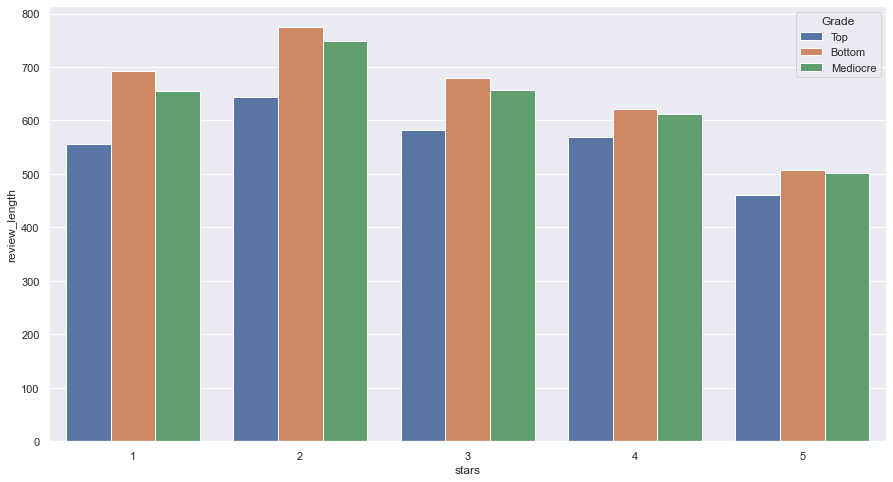

In [30]:
my_data['review_length'] = my_data['text'].map(len)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x="stars", y="review_length", hue="Grade", ci= None, data=my_data)

Positive and Negative sentiment Word Clouds for Top, Mediocre and Bottom restaurants  

In [31]:

def red_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 100%, 40%)"

def green_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(120, 100%, 20%)"

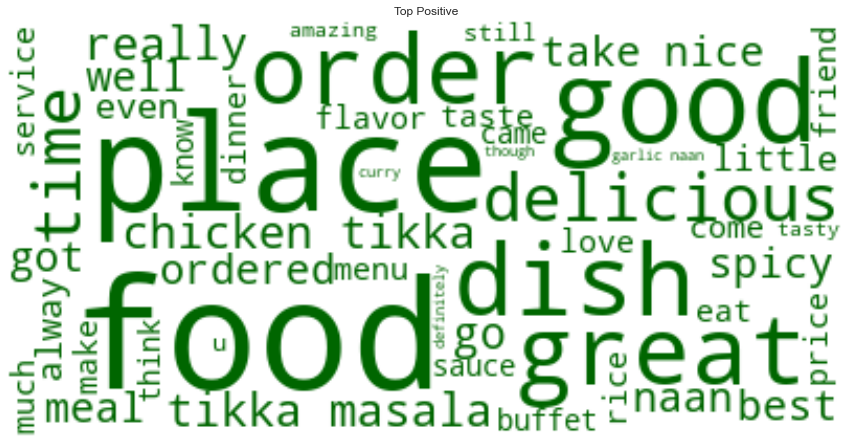

In [32]:
my_top_positive = my_data.loc[(my_data['Grade'] == 'Top') & (my_data['review_category'] == 'Positive')]

text = " ".join(review for review in my_top_positive.clean)

wordcloud = WordCloud(max_words=50, background_color="white").generate(text)
plt.figure()
plt.title("Top Positive")
plt.imshow(wordcloud.recolor(color_func=green_color_func), interpolation="bilinear")  
plt.axis("off")
plt.show()
wordcloud.to_file('TopPositive.png')

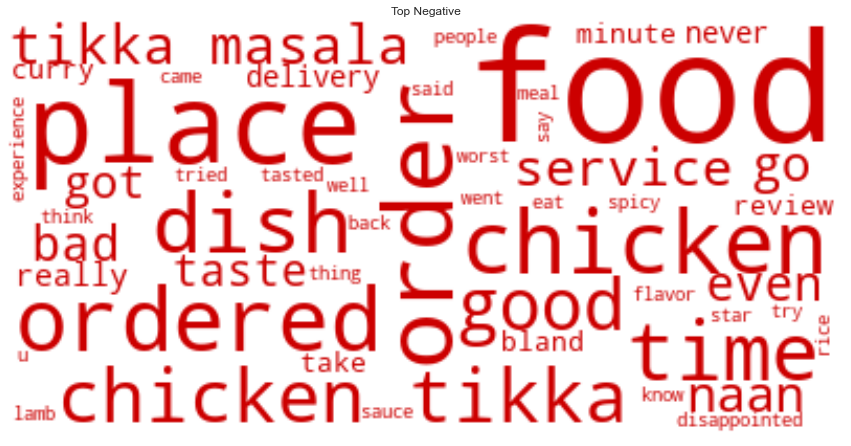

In [33]:
my_top_negative = my_data.loc[(my_data['Grade'] == 'Top') & (my_data['review_category'] == 'Negative')]

text = " ".join(review for review in my_top_negative.clean)

wordcloud = WordCloud(max_words=50, background_color="white").generate(text)
plt.figure()
plt.title("Top Negative")
plt.imshow(wordcloud.recolor(color_func=red_color_func), interpolation="bilinear")  
plt.axis("off")
plt.show()
wordcloud.to_file('TopNegative.png')

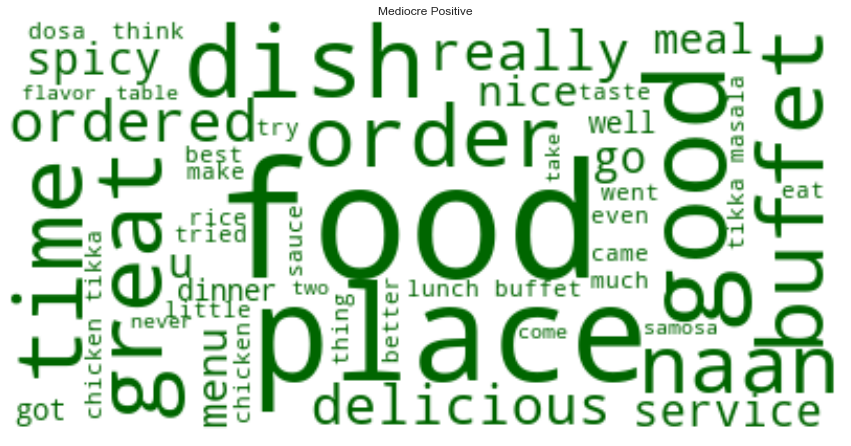

In [34]:
my_med_positive = my_data.loc[(my_data['Grade'] == 'Mediocre') & (my_data['review_category'] == 'Positive')]

text = " ".join(review for review in my_med_positive.clean)

wordcloud = WordCloud(max_words=50, background_color="white").generate(text)
plt.figure()
plt.title("Mediocre Positive")
plt.imshow(wordcloud.recolor(color_func=green_color_func), interpolation="bilinear")  
plt.axis("off")
plt.show()
wordcloud.to_file('MediocrePositive.png')

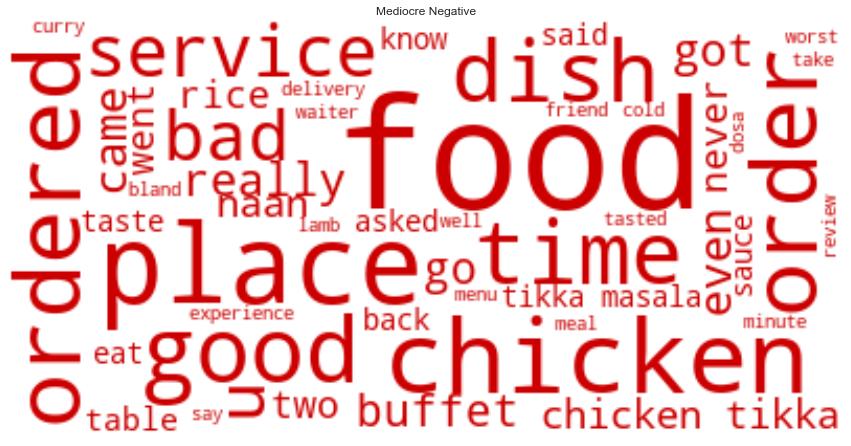

In [35]:
my_med_negative = my_data.loc[(my_data['Grade'] == 'Mediocre') & (my_data['review_category'] == 'Negative')]

text = " ".join(review for review in my_med_negative.clean)

wordcloud = WordCloud(max_words=50,background_color="white").generate(text)
plt.figure()
plt.title("Mediocre Negative")
plt.imshow(wordcloud.recolor(color_func=red_color_func), interpolation="bilinear")  
plt.axis("off")
plt.show()
wordcloud.to_file('MediocreNegative.png')

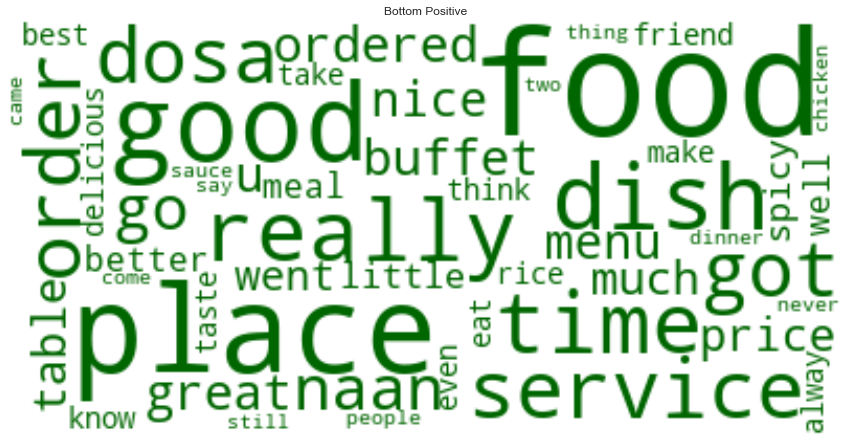

In [36]:
my_bot_positive = my_data.loc[(my_data['Grade'] == 'Bottom') & (my_data['review_category'] == 'Positive')]

text = " ".join(review for review in my_bot_positive.clean)

wordcloud = WordCloud(max_words=50,background_color="white").generate(text)
plt.figure()
plt.title("Bottom Positive")
plt.imshow(wordcloud.recolor(color_func=green_color_func), interpolation="bilinear")  
plt.axis("off")
plt.show()
wordcloud.to_file('BottomPositive.png')

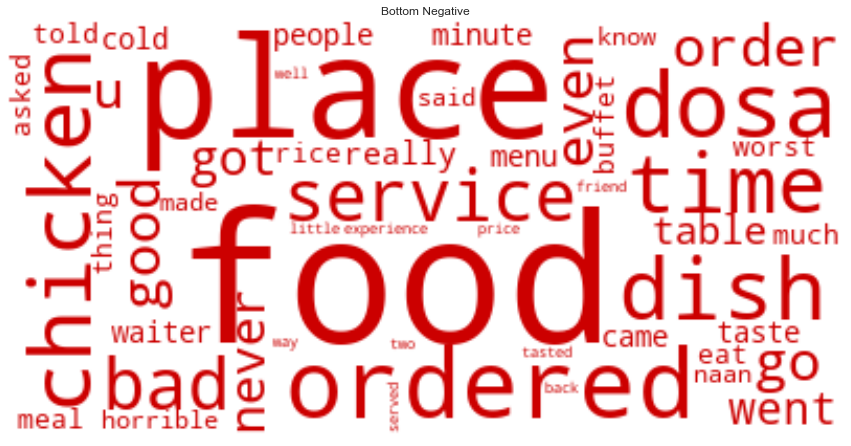

In [37]:
my_bot_negative = my_data.loc[(my_data['Grade'] == 'Bottom') & (my_data['review_category'] == 'Negative')]

text = " ".join(review for review in my_bot_negative.clean)

wordcloud = WordCloud(max_words=50,background_color="white").generate(text)
plt.figure()
plt.title("Bottom Negative")
plt.imshow(wordcloud.recolor(color_func=red_color_func), interpolation="bilinear") 
plt.axis("off")
plt.show()
wordcloud.to_file('BottomNegative.png')

In [38]:
def get_aspects(text):
    doc=nlp(text)
    noun_adj_pairs=[]
    #print([ (c, c.pos_) for c in doc])
    for i,token in enumerate(doc):
      
        ### Extract noun, adjective pairs where adjectives are after the noun (eg:the food was (not) tasty)
        
        if token.pos_ in ('NOUN','PROPN'):
            if i <len(doc)-1 :
                adj=''
                
                for j in range(i+1,len(doc)):
                    
                    if doc[j].text in  ['no', 'not']:  
                        adj += 'not '
    
                    if doc[j].pos_   == 'ADJ':
                        adj += doc[j].text 
                        noun_adj_pairs.append((token.text,adj))
                        break
        
        ### Extract noun, adjective pairs where adjectives are before the nouns (eg: the tasty food)
        
        if token.pos_ in ('ADJ'):
            if i <len(doc) -1:
                if doc[i+1].pos_ in ('NOUN'):
                    noun_adj_pairs.append((doc[i+1].text, token.text))
                    break

    return noun_adj_pairs

In [39]:
all_aspects=[]

Top vs. Mediocre vs. Bottom Aspects Analysis

In [41]:
def extract_lis_of_list(lst):
    return [i[0] for item in lst for i in item]
def extract(lst):
    return [item[0] for item in lst]

aspects-adjectives for Top grade restaurants

In [42]:
#combine reviews for top restaurant 
top_reviews = my_data[(my_data.Grade=='Top')] 
#& (my_data.stars<=3)

#calculate aspect-sentiment pairs for each clean review
top_reviews['aspects']=top_reviews['clean'].apply(get_aspects)

list_of_aspects = top_reviews['aspects'].to_list()
#create list of all aspect-sentiment pair combined for all reviews 
flat_list = [item for sublist in list_of_aspects for item in sublist]

#create a dictionary with aspect as key and list of all sentiments as value
all_asspects=defaultdict(list)
for aspect in flat_list:
    all_asspects[aspect[0]].append(aspect[1])
    
# find top 5 aspects
aspect_count=[]
for aspect, sentiment in all_asspects.items():
    aspect_count.append((aspect, len(sentiment)))
    
aspect_count.sort(key=lambda x: x[1], reverse=True)
top_5_aspects = extract(aspect_count[:5])


aspect_adj=defaultdict(list)
aspect_adj_counter= defaultdict(list)

for aspect, adj in all_asspects.items():
    aspect_adj[aspect].append(set(adj))
    if(aspect in top_5_aspects):
        aspect_adj_counter[aspect].append(Counter(adj).most_common(5))

        
top_5_aspects_adj = {}
top_5_aspects_adj_list = []
for aspect, adj in aspect_adj_counter.items():
    top_5_aspects_adj[aspect]= extract_lis_of_list(adj)
    top_5_aspects_adj_list.append([aspect,extract_lis_of_list(adj)])

(top_5_aspects_adj_list)


[['place', ['good', 'great', 'best', 'favorite', 'amazing']],
 ['food', ['good', 'best', 'great', 'delicious', 'amazing']],
 ['chicken', ['good', 'delicious', 'great', 'best', 'spicy']],
 ['lunch', ['good', 'great', 'special', 'best', 'excellent']],
 ['time', ['good', 'many', 'great', 'several', 'second']]]

In [43]:
aspect_adj_counter

defaultdict(list,
            {'place': [[('good', 94),
               ('great', 82),
               ('best', 66),
               ('favorite', 58),
               ('amazing', 37)]],
             'food': [[('good', 262),
               ('best', 226),
               ('great', 206),
               ('delicious', 109),
               ('amazing', 81)]],
             'chicken': [[('good', 48),
               ('delicious', 25),
               ('great', 22),
               ('best', 17),
               ('spicy', 15)]],
             'lunch': [[('good', 26),
               ('great', 23),
               ('special', 18),
               ('best', 10),
               ('excellent', 8)]],
             'time': [[('good', 32),
               ('many', 26),
               ('great', 26),
               ('several', 20),
               ('second', 17)]]})

aspects-adjectives for Mediocre grade restaurants

In [44]:
#combine reviews for mediocre restaurant 
med_reviews = my_data[(my_data.Grade=='Mediocre')] 
#& (my_data.stars<=3)

#calculate aspect-sentiment pairs for each clean review
med_reviews['aspects']=med_reviews['clean'].apply(get_aspects)

list_of_aspects = med_reviews['aspects'].to_list()
#create list of all aspect-sentiment pair combined for all reviews 
flat_list = [item for sublist in list_of_aspects for item in sublist]

#create a dictionary with aspect as key and list of all sentiments as value
all_asspects=defaultdict(list)
for aspect in flat_list:
    all_asspects[aspect[0]].append(aspect[1])
    
# find top 5 aspects
aspect_count=[]
for aspect, sentiment in all_asspects.items():
    aspect_count.append((aspect, len(sentiment)))
    
aspect_count.sort(key=lambda x: x[1], reverse=True)
top_5_aspects = extract(aspect_count[:5])


aspect_adj=defaultdict(list)
aspect_adj_counter= defaultdict(list)

for aspect, adj in all_asspects.items():
    aspect_adj[aspect].append(set(adj))
    if(aspect in top_5_aspects):
        aspect_adj_counter[aspect].append(Counter(adj).most_common(5))

        
top_5_aspects_adj = {}
top_5_aspects_adj_list = []
for aspect, adj in aspect_adj_counter.items():
    top_5_aspects_adj[aspect]= extract_lis_of_list(adj)
    top_5_aspects_adj_list.append([aspect,extract_lis_of_list(adj)])

(top_5_aspects_adj_list)


[['lunch', ['good', 'great', 'favorite', 'old', 'best']],
 ['place', ['good', 'great', 'favorite', 'best', 'amazing']],
 ['food', ['good', 'great', 'best', 'delicious', 'fast']],
 ['time', ['several', 'many', 'great', 'long', 'good']],
 ['buffet', ['good', 'great', 'decent', 'delicious', 'tasty']]]

In [45]:
aspect_adj_counter

defaultdict(list,
            {'lunch': [[('good', 34),
               ('great', 18),
               ('favorite', 7),
               ('old', 6),
               ('best', 6)]],
             'place': [[('good', 45),
               ('great', 44),
               ('favorite', 27),
               ('best', 18),
               ('amazing', 17)]],
             'food': [[('good', 119),
               ('great', 82),
               ('best', 60),
               ('delicious', 42),
               ('fast', 35)]],
             'time': [[('several', 21),
               ('many', 12),
               ('great', 11),
               ('long', 11),
               ('good', 11)]],
             'buffet': [[('good', 42),
               ('great', 20),
               ('decent', 10),
               ('delicious', 6),
               ('tasty', 5)]]})

aspects-adjectives for Bottom grade restaurants

In [46]:
#combine reviews for bottom restaurant 
bot_reviews = my_data[(my_data.Grade=='Bottom')] 
# & (my_data.stars<=3)
#calculate aspect-sentiment pairs for each clean review
bot_reviews['aspects']=bot_reviews['clean'].apply(get_aspects)

list_of_aspects = bot_reviews['aspects'].to_list()
#create list of all aspect-sentiment pair combined for all reviews 
flat_list = [item for sublist in list_of_aspects for item in sublist]

#create a dictionary with aspect as key and list of all sentiments as value
all_asspects=defaultdict(list)
for aspect in flat_list:
    all_asspects[aspect[0]].append(aspect[1])
    
# find top 5 aspects
aspect_count=[]
for aspect, sentiment in all_asspects.items():
    aspect_count.append((aspect, len(sentiment)))
    
aspect_count.sort(key=lambda x: x[1], reverse=True)
top_5_aspects = extract(aspect_count[:5])


aspect_adj=defaultdict(list)
aspect_adj_counter= defaultdict(list)

for aspect, adj in all_asspects.items():
    aspect_adj[aspect].append(set(adj))
    if(aspect in top_5_aspects):
        aspect_adj_counter[aspect].append(Counter(adj).most_common(5))

        
top_5_aspects_adj = {}
top_5_aspects_adj_list = []
for aspect, adj in aspect_adj_counter.items():
    top_5_aspects_adj[aspect]= extract_lis_of_list(adj)
    top_5_aspects_adj_list.append([aspect,extract_lis_of_list(adj)])

(top_5_aspects_adj_list)


[['food', ['good', 'great', 'chinese', 'bad', 'worst']],
 ['place', ['great', 'good', 'worst', 'best', 'bad']],
 ['lunch', ['good', 'great', 'small', 'whole', 'tasty']],
 ['time', ['long', 'good', 'second', 'rude', 'several']],
 ['buffet', ['good', 'small', 'much', 'great', 'extra']]]

In [47]:
aspect_adj_counter

defaultdict(list,
            {'food': [[('good', 80),
               ('great', 42),
               ('chinese', 26),
               ('bad', 20),
               ('worst', 20)]],
             'place': [[('great', 27),
               ('good', 21),
               ('worst', 13),
               ('best', 10),
               ('bad', 8)]],
             'lunch': [[('good', 14),
               ('great', 8),
               ('small', 5),
               ('whole', 4),
               ('tasty', 4)]],
             'time': [[('long', 12),
               ('good', 9),
               ('second', 8),
               ('rude', 6),
               ('several', 5)]],
             'buffet': [[('good', 13),
               ('small', 5),
               ('much', 5),
               ('great', 5),
               ('extra', 4)]]})